In [1]:
from os import environ
environ['OMP_NUM_THREADS'] = '12'
import numpy as np
import scipy.linalg as la
from qiskit import QuantumCircuit, Aer, execute
from qiskit.extensions import UnitaryGate
import matplotlib.pyplot as plt

C:\Users\lisis\AppData\Local\Temp\ipykernel_7740\2437713394.py:6: DeprecationWarning: The qiskit.extensions module is deprecated since Qiskit 0.46.0. It will be removed in the Qiskit 1.0 release.
  from qiskit.extensions import UnitaryGate


In [55]:
qubit_num = 3 #число кубитов для вычисления собственного значения
# real_unitary_eigs = np.repeat(
#     a=[la.expm(1j*2*np.pi*(1)/(2**qubit_num)) for _ in range(2**qubit_num)],
#     repeats=1)

alpha = np.pi/4#np.arccos(np.pi/4) #np.pi/4
# alpha = 0
# U = la.expm(np.matrix([[0,-alpha,0,0],[alpha,0,0,0],[0,0,1j,0],[0,0,0,1j]]))
# U = la.expm(np.matrix([[np.cos(alpha),np.sin(alpha),0,0],[-np.sin(alpha),np.cos(alpha), 0,0],[0,0,1j,0],[0,0,0,1j]]))
# U = np.array([[np.cos(alpha),np.sin(alpha),0,0],[-np.sin(alpha),np.cos(alpha), 0,0],[0,0,1,0],[0,0,0,1]])
U = np.array([[np.cos(alpha),np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]])
print(U)
UnitaryGate(U)
# alpha = np.arccos(np.pi/4 + 0.0001)
alpha = np.pi/4 #+ 0.2#+0.04#0 + 1/4
# alpha = 0 #+ 0.2
# # U_noised = la.expm(np.matrix([[0,-alpha,0,0],[alpha,0,0,0],[0,0,1j,0],[0,0,0,1j]]))
# U_noised = np.array([[np.cos(alpha),np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]])
U_noised = U + 

print(U_noised)
# UnitaryGate(U_noised)

# real_unitary_eigs[1] = la.expm(1j*2*np.pi*1/(2**qubit_num))
# real_unitary_eigs[2] = la.expm(1j*2*np.pi*1/(2**qubit_num))
# real_unitary_eigs[3] = la.expm(1j*2*np.pi*1/(2**qubit_num))
# real_unitary_eigs[4] = la.expm(1j*2*np.pi*1/(2**qubit_num))
# real_hermitian_eigs = [np.log(i) for i in real_unitary_eigs]
# real_A = np.diag(real_hermitian_eigs).astype('complex')
# real_U = la.expm(1*real_A)
# # np.round(real_U,2)
# real_eigs_u, real_vecs_u = np.linalg.eig(real_U)
# eigs_u, vecs_u = real_eigs_u, real_vecs_u
# U = real_U
eigs_u, vecs_u = np.linalg.eig(U)
# U = U.astype('complex')
U = U_noised
# print(U)
# print(U + [[-0.01, 0.01], [0.01, -0.01]])
# vector = vecs_u[:,1]
# print(vector.shape)
# print(np.linalg.eig(U_noised)[1])
# print(np.shape(U))
# print([np.arctan(eig.imag/eig.real)/(2*np.pi) for eig in eigs_u])
# print(np.sin(alpha))
# np.round(real_U,2)
# eigs_u = real_eigs_u
# print(np.arccos(3/4))

[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


In [56]:
print(eigs_u)
print([eig.imag/eig.real for eig in eigs_u])
print([np.arctan(eig.imag/eig.real)/(2*np.pi) for eig in eigs_u])

[0.70710678+0.70710678j 0.70710678-0.70710678j]
[1.0000000000000002, -1.0000000000000002]
[0.12500000000000003, -0.12500000000000003]


In [57]:
# np.tan(0.125*(2*np.pi))*0.2

In [58]:
def noise_val():
    return np.random.normal(0,0.1,1)[0] #+  1.j*np.random.normal(0,0.3,1)[0]
    # return 0.1#+0.1j

In [59]:
# noised_unitary_eigs = np.repeat(
#     a=[la.expm(1j*2*np.pi*(1+noise_val())/(2**qubit_num)) for _ in range(2**qubit_num)],
#     repeats=1)
# # noised_unitary_eigs[1] = la.expm(1j*2*np.pi*(2+noise_val())/(2**qubit_num))
# # noised_unitary_eigs[2] = la.expm(1j*2*np.pi*(3+noise_val())/(2**qubit_num))
# # noised_unitary_eigs[3] = la.expm(1j*2*np.pi*(4+noise_val())/(2**qubit_num))
# # noised_unitary_eigs[4] = la.expm(1j*2*np.pi*(5+noise_val())/(2**qubit_num))
# noised_hermitian_eigs = [np.log(i) for i in noised_unitary_eigs]
# noised_A = np.diag(noised_hermitian_eigs).astype('complex')
# noised_U = la.expm(1*noised_A)
# from qiskit.extensions import UnitaryGate
# UnitaryGate(noised_U)
# U = noised_U
# print(U)
# noised_eigs_u, noised_vecs_u = np.linalg.eig(noised_U)
# vecs_u = noised_vecs_u

In [60]:
# U

In [61]:
# print(real_hermitian_eigs)
# print(noised_hermitian_eigs)

In [62]:
# eig = la.expm(1j*2*np.pi*(1+1/32)/(2**qubit_num))
# phase = np.log(eig) * 2** qubit_num / (1j*2*np.pi)
# print(f"real phase {1+1/32} and calculated {phase}")

In [63]:
# U = np.load('matrix.npy')
# eigs_u, vecs_u = np.linalg.eig(U)
# print(eigs_u[0])
# (np.arctan(0.835716070437315/0.5491617699847768))

In [64]:
#states
state_zero = np.array([[1.0],[0.0]])
state_one = np.array([[0.0],[1.0]])
#projectors
P0 = np.dot(state_zero, state_zero.T)
P1 = np.dot(state_one, state_one.T)

In [65]:
def multi_kron(*args):
    ret = np.array([[1.0]]).astype('complex')
    for q in args: 
        ret = np.kron(ret, q)
    return ret

def multi_dot(*args):
    ret = np.eye(np.shape(args[0])[0]).astype('complex')
    for q in args:
        ret = np.dot(ret, q)
    return ret

In [66]:
def H():
    return 1/np.sqrt(2) * np.array([[1, 1],
                                    [1, -1]]).astype('complex')
def X():
    return np.array([[0, 1],
                     [1, 0]]).astype('complex')
def Rz(phi):
    return np.array([[np.exp(-1j*phi/2), 0],
                     [0, np.exp(1j*phi/2)]]).astype('complex')
def P(phi):
    return np.array([[1, 0],
                     [0, np.exp(1j*phi)]]).astype('complex')
def Ry(theta):
    return np.array([[np.cos(theta/2), -np.sin(theta/2)],
                     [np.sin(theta/2), np.cos(theta/2)]]).astype('complex')
def I():
    return np.array([[1, 0],
                     [0, 1]]).astype('complex')

#for some reson CONTROL and TARGET are changed
def control(control_q, target_q, n_of_qubits, operator):
    list_of_ops_left = []
    list_of_ops_right = []
    stop = False
    for i in range(n_of_qubits):
        if i in control_q:
            list_of_ops_left.append(P0)
            list_of_ops_right.append(P1)
        elif i in target_q:
            if np.shape(U) != (2, 2):
                if not stop:
                    for _ in range(len(target_q)):
                        list_of_ops_left.append(I())
                    list_of_ops_right.append(operator)
                    stop = True
            else:
                list_of_ops_left.append(I())
                list_of_ops_right.append(operator)
        else:
            list_of_ops_left.append(I())
            list_of_ops_right.append(I())
    return multi_kron(*list_of_ops_left) + multi_kron(*list_of_ops_right).astype('complex')

In [67]:
#eigenvalues to phases
def eigenvalues_to_phases(n, u):
    # print(n)
    repetitions = 1#2**(n-1)
    ops = []
    target_qubits_amount = int(np.log2(u.shape[0]))
    for i in range(0, n):
        for _ in range(repetitions):
            ops.append(control(control_q=[target_qubits_amount-1+n-i],
                               target_q=[idx for idx in range(target_qubits_amount)],
                               n_of_qubits=n+target_qubits_amount,
                               operator=u**1
                               ))
        repetitions *= 2
    return multi_dot(*ops)

In [78]:

def swap(n_of_qubs,u):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    target_qubits_amount = int(np.log2(u.shape[0]))
    qc = QuantumCircuit(n_of_qubs+target_qubits_amount)
    for qubit in range(n_of_qubs//2): #n//2
        qc.swap(qubit, n_of_qubs-qubit-1)
    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend)
    result = job.result()
    op = result.get_unitary(qc).data
    return op

def iqft(n, u):
    ops = []
    target_qubits_amount = int(np.log2(u.shape[1]))
    hadamards = np.array([I() for _ in range(n+target_qubits_amount)])
    for j in range(n): 
        print('next level')
        print(target_qubits_amount - 1 + n - j)
        for m in range(j):
            print(f'control{target_qubits_amount - 1 + n - m} \n target_q{target_qubits_amount - 1 + n - j}')
            ops.append(
                control(
                control_q=[target_qubits_amount - 1 + n - m],
                target_q=[target_qubits_amount - 1 + n - j],
                n_of_qubits=n + target_qubits_amount,
                operator=P(-np.pi/float(2**(j-m))),
                )
            )
        hadamards_ = hadamards.copy()
        print('hadamard here', target_qubits_amount - 1 + n - j)
        hadamards_[target_qubits_amount - 1 + n - j] = H()
        ops.append(multi_kron(*hadamards_))
    return multi_dot(*ops)

In [79]:
prime_state = multi_kron(
    np.array([[el] for el in vecs_u[:,0]]),
    *[state_zero for _ in range(qubit_num)])


# prime_state = multi_kron(
#     np.array([[el] for el in [1,0,0,0]]),
#     *[state_zero for _ in range(qubit_num)])
#state preparation
state_prep = multi_kron(*[I() for _ in range(int(np.log2(len(vecs_u[1]))))],
                        *[H() for _ in range(qubit_num)])
#calculations
eigs_to_phases = eigenvalues_to_phases(qubit_num, U)
iqft_matrix = iqft(qubit_num, U)
ift = multi_dot(swap(qubit_num, U), iqft_matrix)
final_u = multi_dot(ift, eigs_to_phases, state_prep)
final_state = np.dot(final_u, prime_state)
rho = np.dot(final_state, np.conj(final_state).T)
# vecs_u

next level
2
hadamard here 2
next level
1
control2 
 target_q1
hadamard here 1


C:\Users\lisis\AppData\Local\Temp\ipykernel_7740\1926946112.py:9: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc, backend)


In [153]:
max_num = 2**qubit_num
max_prob = 0
eigenvalue = -9999
probs = []
potential_eigs = []
max_bin = 0
for i in range(max_num):
    ops = [I() for _ in range(int(np.log2(len(vecs_u[1]))))]
    bin_int = "{0:b}".format(i).zfill(qubit_num)
    ops.extend([P0 if bit == '0' else P1 for bit in bin_int])
    proj = multi_kron(*ops)
    prob = np.sqrt(np.trace(np.dot(proj, rho))**2)
    probs.append(np.round(prob,3))
    # potential_eigs.append(la.expm(1j*2*np.pi*i/(2**qubit_num)))
    potential_eigs.append(i/(2**qubit_num))
    if prob > max_prob:
        max_prob = prob
        eigenvalue = i/(2**qubit_num)
        max_bin = i
probs = [prob.real for prob in probs]
print(f'calculated phase is {np.round(eigenvalue, 3)}')
print(f'true phases are {np.round([np.arctan(eig.imag/eig.real)/(2*np.pi) for eig in eigs_u], 3)}')
print(f'all probabilitis {probs}')
print(f'for the potential phases {potential_eigs}')
# print(f'dispersion', np.std(probs))

calculated phase is 0.125
true phases are [ 0.125 -0.125]
all probabilitis [0.0, 1.051, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
for the potential phases [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]


In [113]:
# [np.arctan(eig.imag/eig.real) for eig in eigs_u]
# [np.arctan(eig.real/eig.imagine for eig in eigs_u)]

## $\sigma^2$ calculation

In [78]:
import statistics
math_ex = 0
for (prob, val) in zip(probs, np.arange(0,2**qubit_num-1)):
    math_ex += prob.real*val
sigma_2 = 0
for (prob, val) in zip(probs, np.arange(0,2**qubit_num-1)):
    sigma_2 += (val - math_ex)**2 * prob.real
print(f'sigma={sigma_2}, math ex={math_ex}, calculated eig_u from math ex={math_ex / (2 ** qubit_num)}')
print(f'real {np.arctan(eigs_u[1].imag/eigs_u[1].real)/(2*np.pi)}')
# print(sigma_2, math_ex, la.expm(1j * 2 * np.pi * math_ex / (2 ** (qubit_num))))
# print(la.expm(1j * 2 * np.pi * math_ex / (2 ** qubit_num)))

sigma=1.10899526, math ex=0.31400000000000006, calculated eig_u from math ex=0.03925000000000001
real 0.0


In [54]:
import matplotlib.pyplot as plt
plt.bar(np.arange(0, 2**qubit_num), probs_1, 0.25, color='w', hatch='/', facecolor="none", label=r'$phase=1$')
# plt.bar(np.arange(0, 2**qubit_num), probs_1_8, 0.25, color='w', hatch='\\\\', facecolor="none")#, width, bottom, align)
plt.bar(np.arange(0, 2**qubit_num), probs_1_4, 0.25, color='w', hatch='\\', facecolor="none", label=r'$phase=1+\frac{1}{4}$')
plt.bar(np.arange(0, 2**qubit_num), probs_1_2, 0.25, color='w', hatch='.', facecolor="none", label=r'$phase=1+\frac{1}{2}$')
plt.legend(loc="upper left", fontsize="20")
plt.xlabel("measured phases", fontsize="20")
plt.ylabel("probabilities", fontsize="20")
plt.ylim(0,1)
plt.xticks(np.arange(0, 2**qubit_num), rotation=0, fontsize="20")
plt.yticks(fontsize="20")
plt.rcParams["figure.figsize"] = (20,10)
plt.savefig('3_in_1.png')
plt.show()
phase = np.log(eigs_u[0]) * 2** qubit_num / (1j*2*np.pi)
print(phase, eigs_u[0])

NameError: name 'probs_1' is not defined

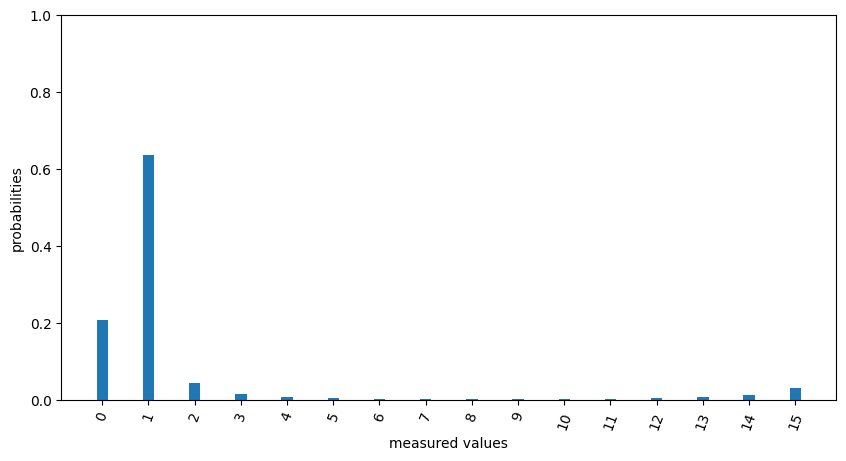

(0.6366197723675815+9.718361526694079e-17j) (0.9689124217106447+0.24740395925452296j)


In [340]:
import matplotlib.pyplot as plt
probs_1_2 = probs
plt.bar(np.arange(0, 2**qubit_num), probs, 0.25)#, width, bottom, align)
plt.xlabel("measured values")
plt.ylabel("probabilities")
plt.ylim(0,1)
plt.xticks(np.arange(0, 2**qubit_num), rotation=70)
plt.rcParams["figure.figsize"] = (10,5)
plt.savefig('1.png')
plt.show()
phase = np.log(eigs_u[0]) * 2** qubit_num / (1j*2*np.pi)
print(phase, eigs_u[0])

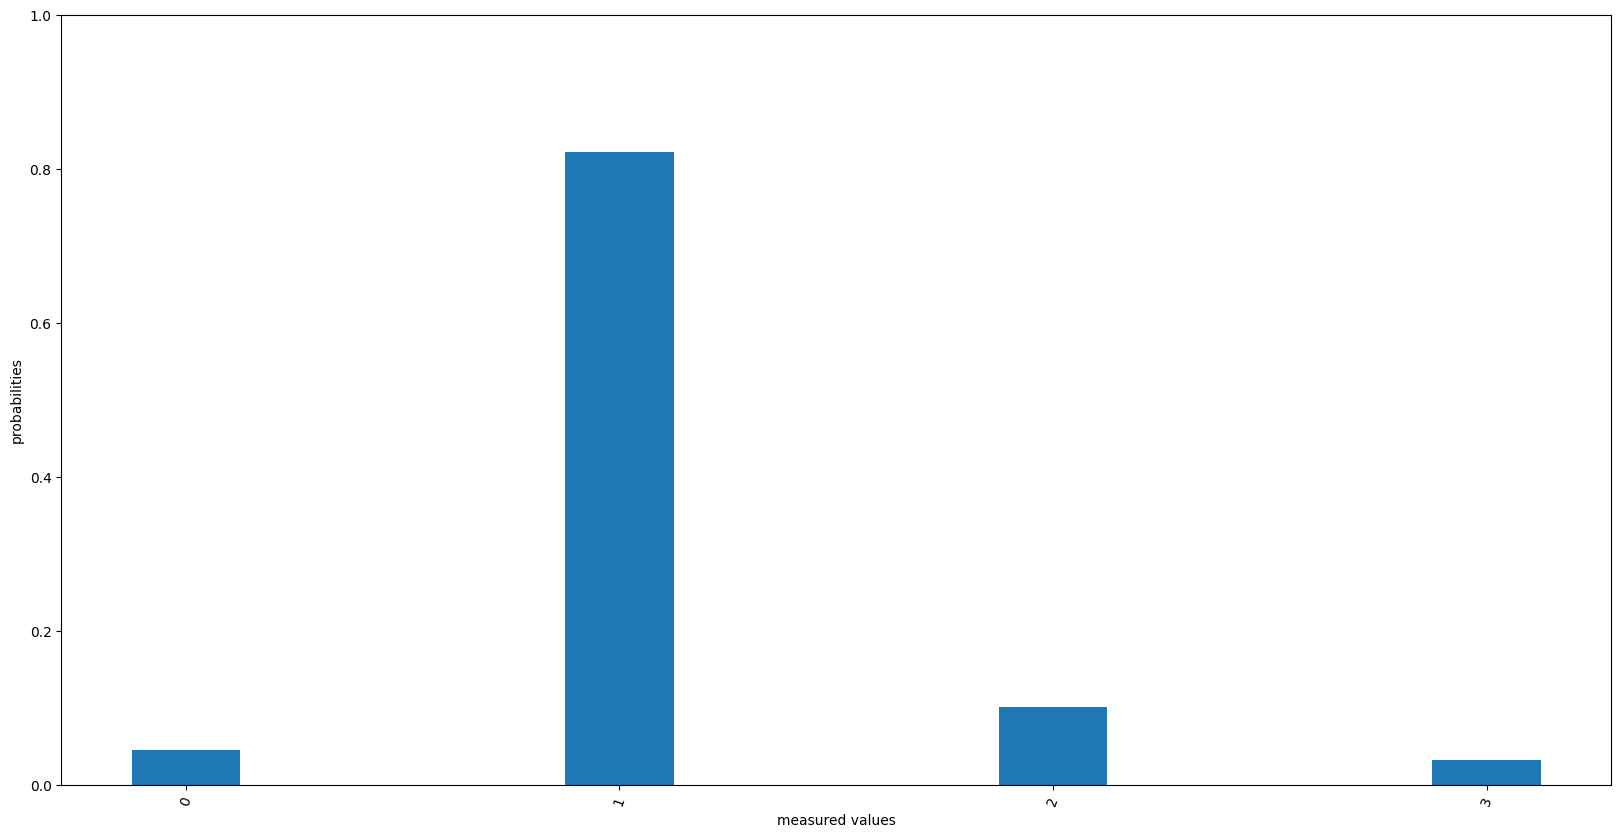

(1.25+1.766974823035287e-17j) (-0.3826834323650897+0.9238795325112867j)


In [98]:
import matplotlib.pyplot as plt
probs_1_4 = probs
plt.bar(np.arange(0, 2**qubit_num), probs, 0.25)#, width, bottom, align)
plt.xlabel("measured values")
plt.ylabel("probabilities")
plt.ylim(0,1)
plt.xticks(np.arange(0, 2**qubit_num), rotation=70)
plt.rcParams["figure.figsize"] = (20,10)
plt.savefig('1.png')
plt.show()
phase = np.log(eigs_u[0]) * 2** qubit_num / (1j*2*np.pi)
print(phase, eigs_u[0])

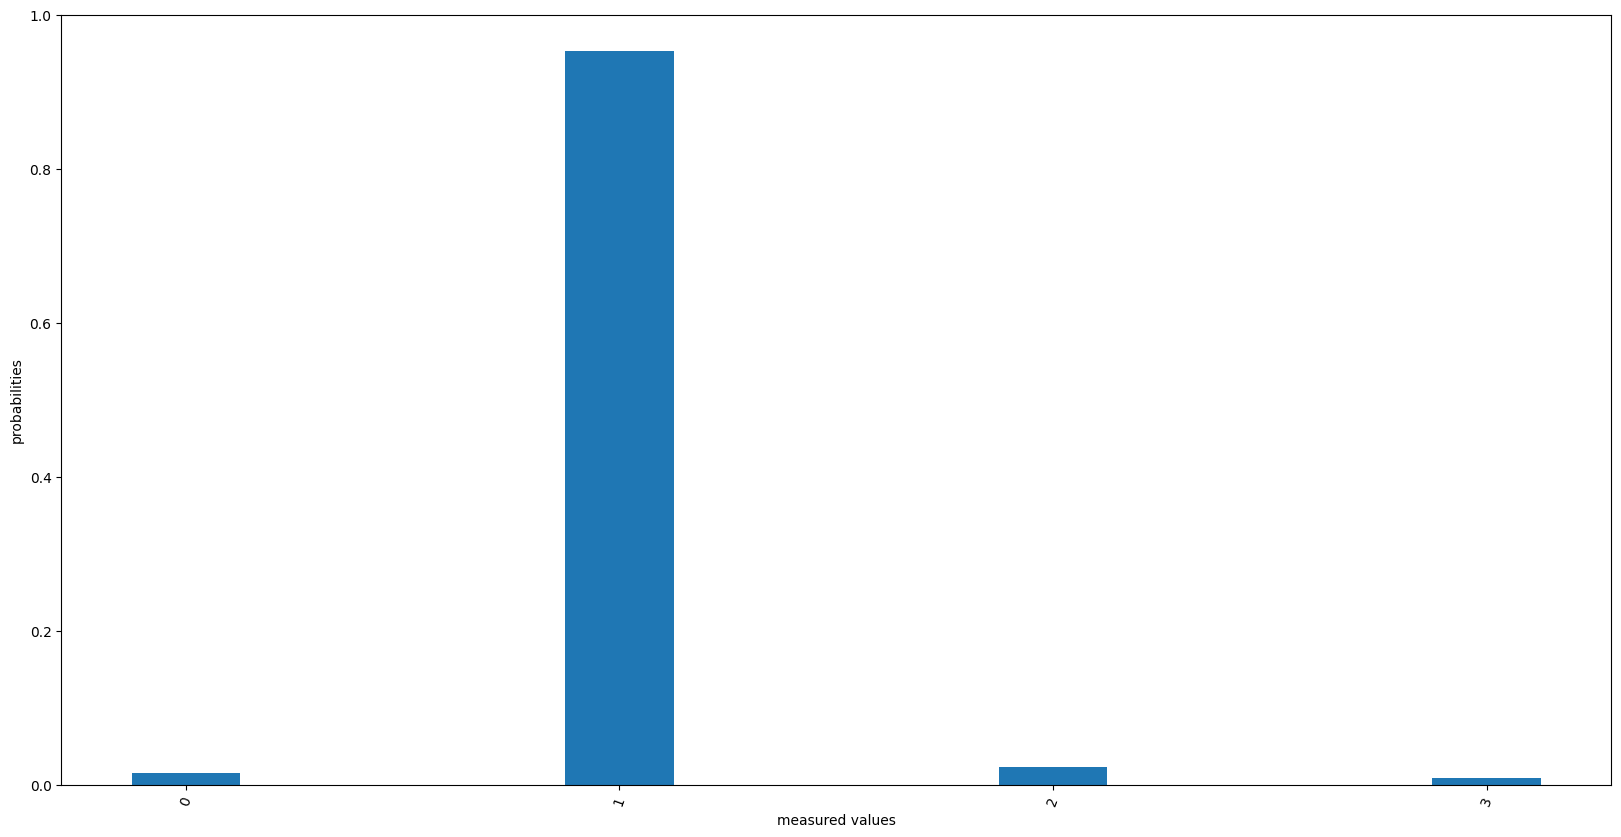

(1.125+2.208718528794109e-17j) (-0.1950903220161282+0.9807852804032304j)


In [84]:
import matplotlib.pyplot as plt
probs_1_8 = probs
plt.bar(np.arange(0, 2**qubit_num), probs, 0.25)#, width, bottom, align)
plt.xlabel("measured values")
plt.ylabel("probabilities")
plt.ylim(0,1)
plt.xticks(np.arange(0, 2**qubit_num), rotation=70)
plt.rcParams["figure.figsize"] = (20,10)
plt.savefig('1.png')
plt.show()
phase = np.log(eigs_u[0]) * 2** qubit_num / (1j*2*np.pi)
print(phase, eigs_u[0])

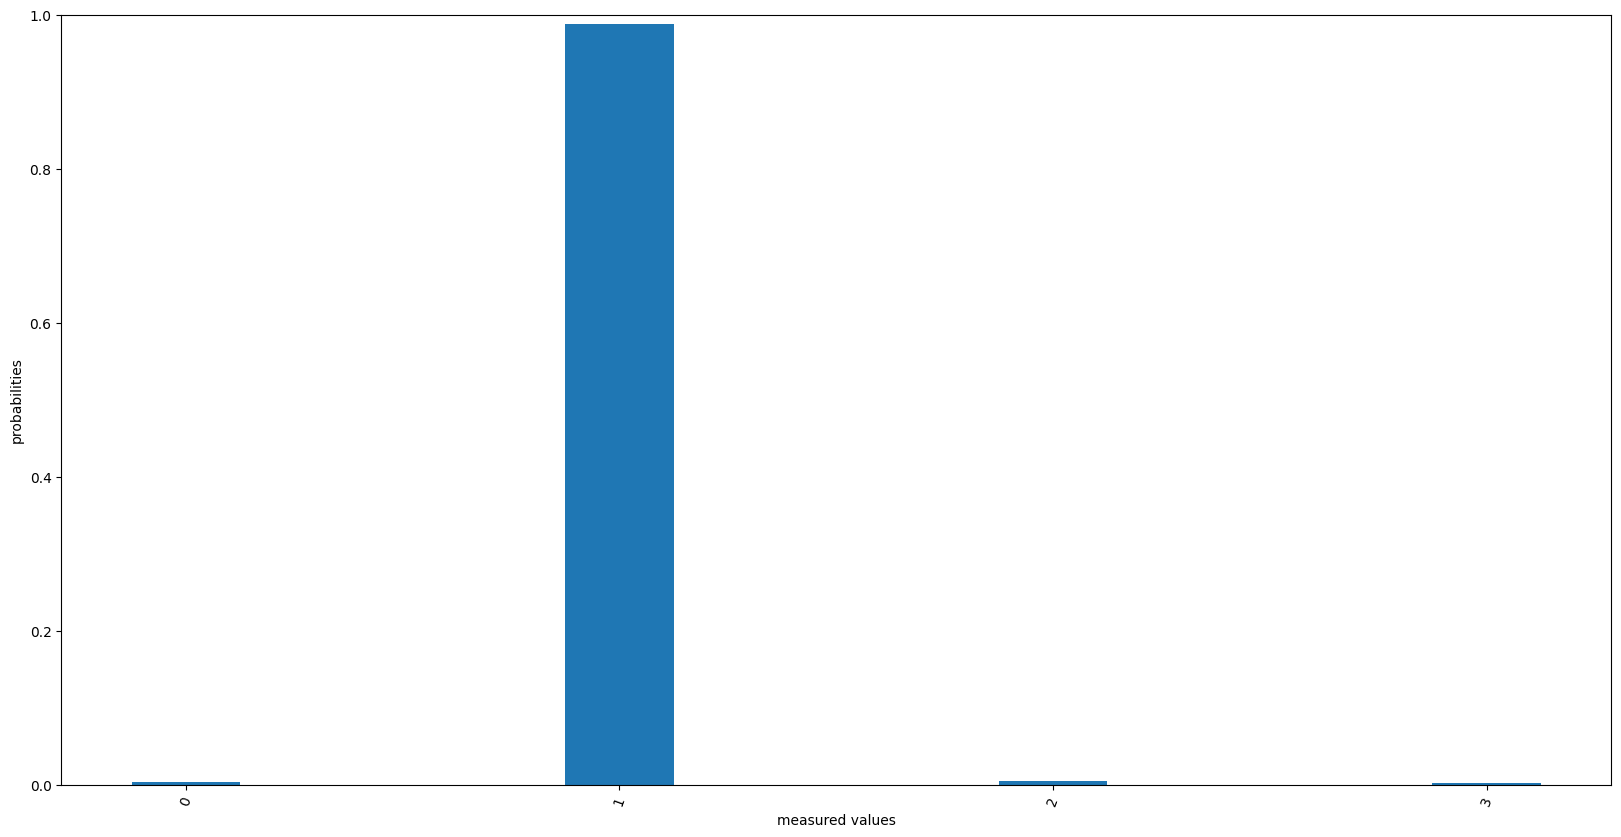

(1.0625-2.9817700138720473e-17j) (-0.09801714032956065+0.9951847266721969j)


In [70]:
import matplotlib.pyplot as plt
probs_1_16 = probs
plt.bar(np.arange(0, 2**qubit_num), probs, 0.25)#, width, bottom, align)
plt.xlabel("measured values")
plt.ylabel("probabilities")
plt.ylim(0,1)
plt.xticks(np.arange(0, 2**qubit_num), rotation=70)
plt.rcParams["figure.figsize"] = (20,10)
plt.savefig('1.png')
plt.show()
phase = np.log(eigs_u[0]) * 2** qubit_num / (1j*2*np.pi)
print(phase, eigs_u[0])

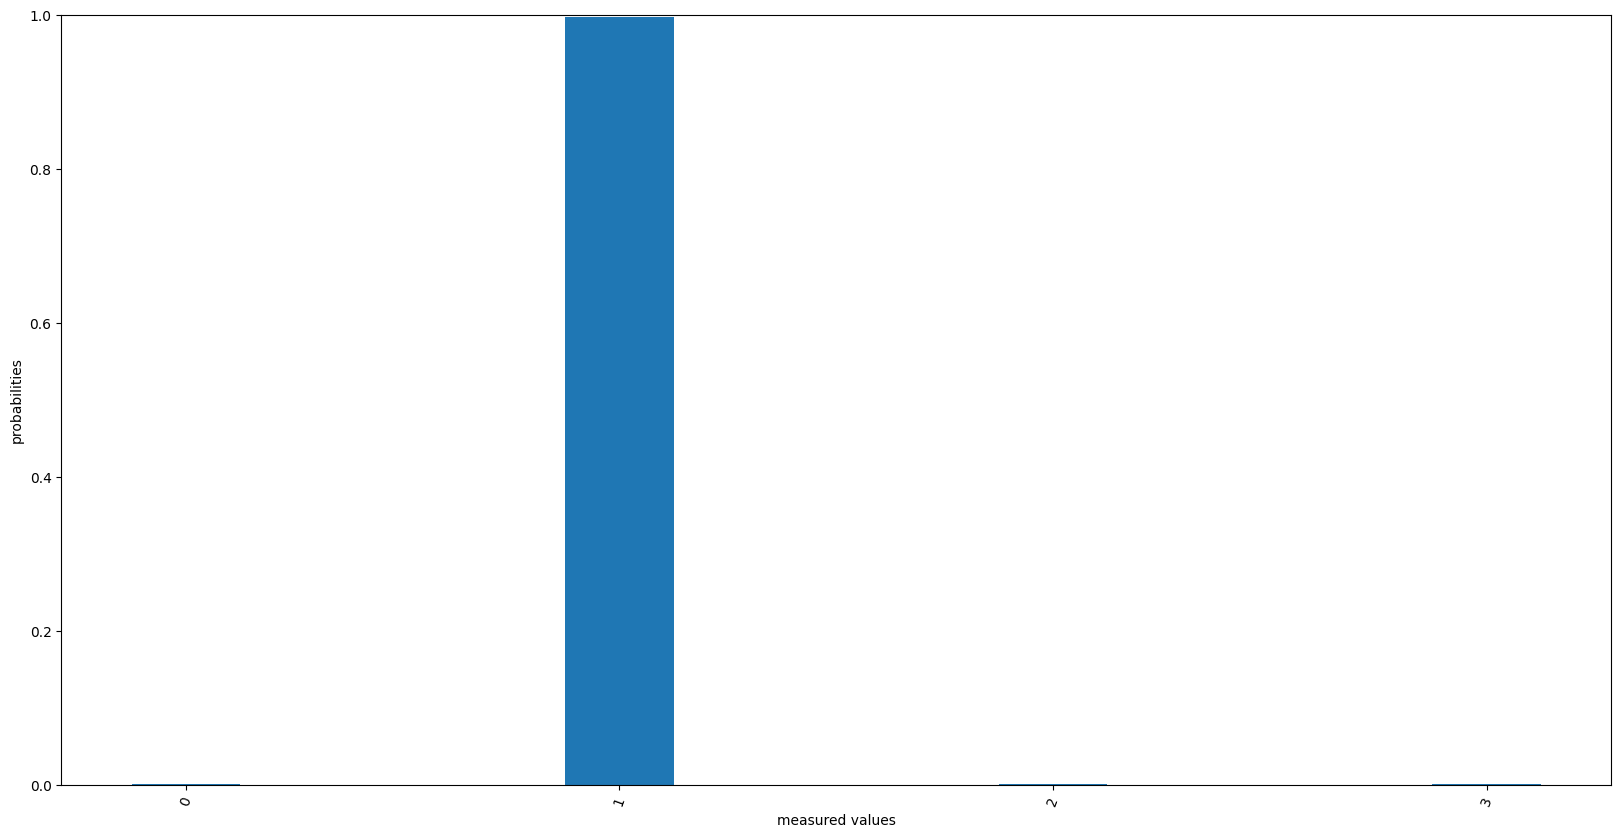

(1.03125-7.730514850779382e-18j) (-0.04906767432741801+0.9987954562051724j)


In [56]:
import matplotlib.pyplot as plt
probs_1_32 = probs
plt.bar(np.arange(0, 2**qubit_num), probs, 0.25)#, width, bottom, align)
plt.xlabel("measured values")
plt.ylabel("probabilities")
plt.ylim(0,1)
plt.xticks(np.arange(0, 2**qubit_num), rotation=70)
plt.rcParams["figure.figsize"] = (20,10)
plt.savefig('1.png')
plt.show()
phase = np.log(eigs_u[0]) * 2** qubit_num / (1j*2*np.pi)
print(phase, eigs_u[0])

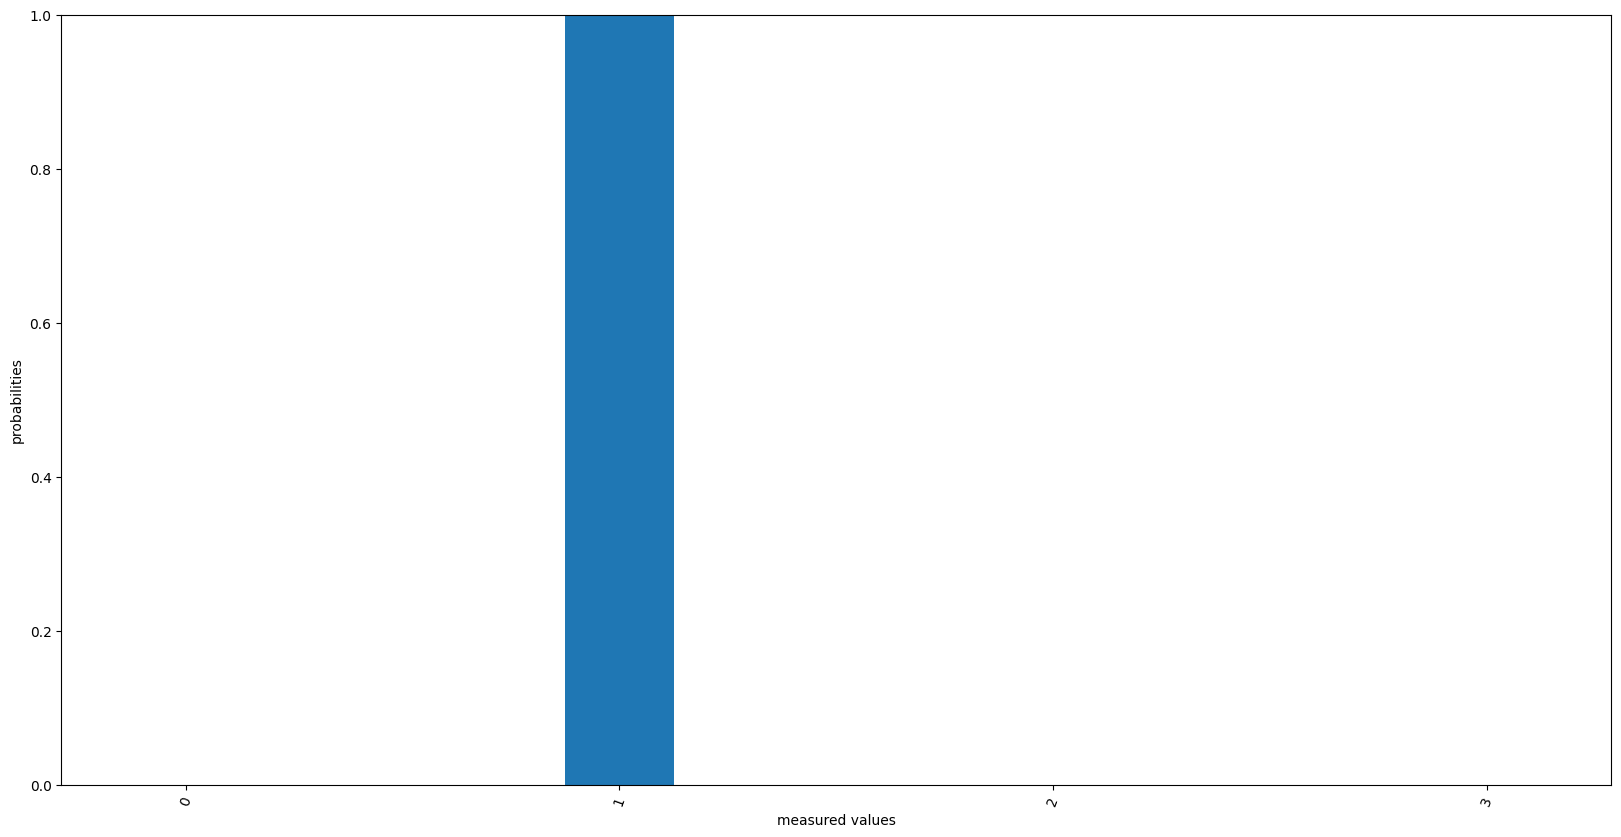

(1-1.1934709143053064e-33j) (6.123233995736766e-17+1j)


In [27]:
import matplotlib.pyplot as plt
probs_1 = probs
plt.bar(np.arange(0, 2**qubit_num), probs, 0.25)#, width, bottom, align)
plt.xlabel("measured values")
plt.ylabel("probabilities")
plt.ylim(0,1)
plt.xticks(np.arange(0, 2**qubit_num), rotation=70)
plt.rcParams["figure.figsize"] = (20,10)
plt.savefig('1.png')
plt.show()
phase = np.log(eigs_u[0]) * 2** qubit_num / (1j*2*np.pi)
print(phase, eigs_u[0])

In [189]:
print(probs)


[0.004, 0.007, 0.024, 0.875, 0.055, 0.011, 0.005, 0.003, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002]


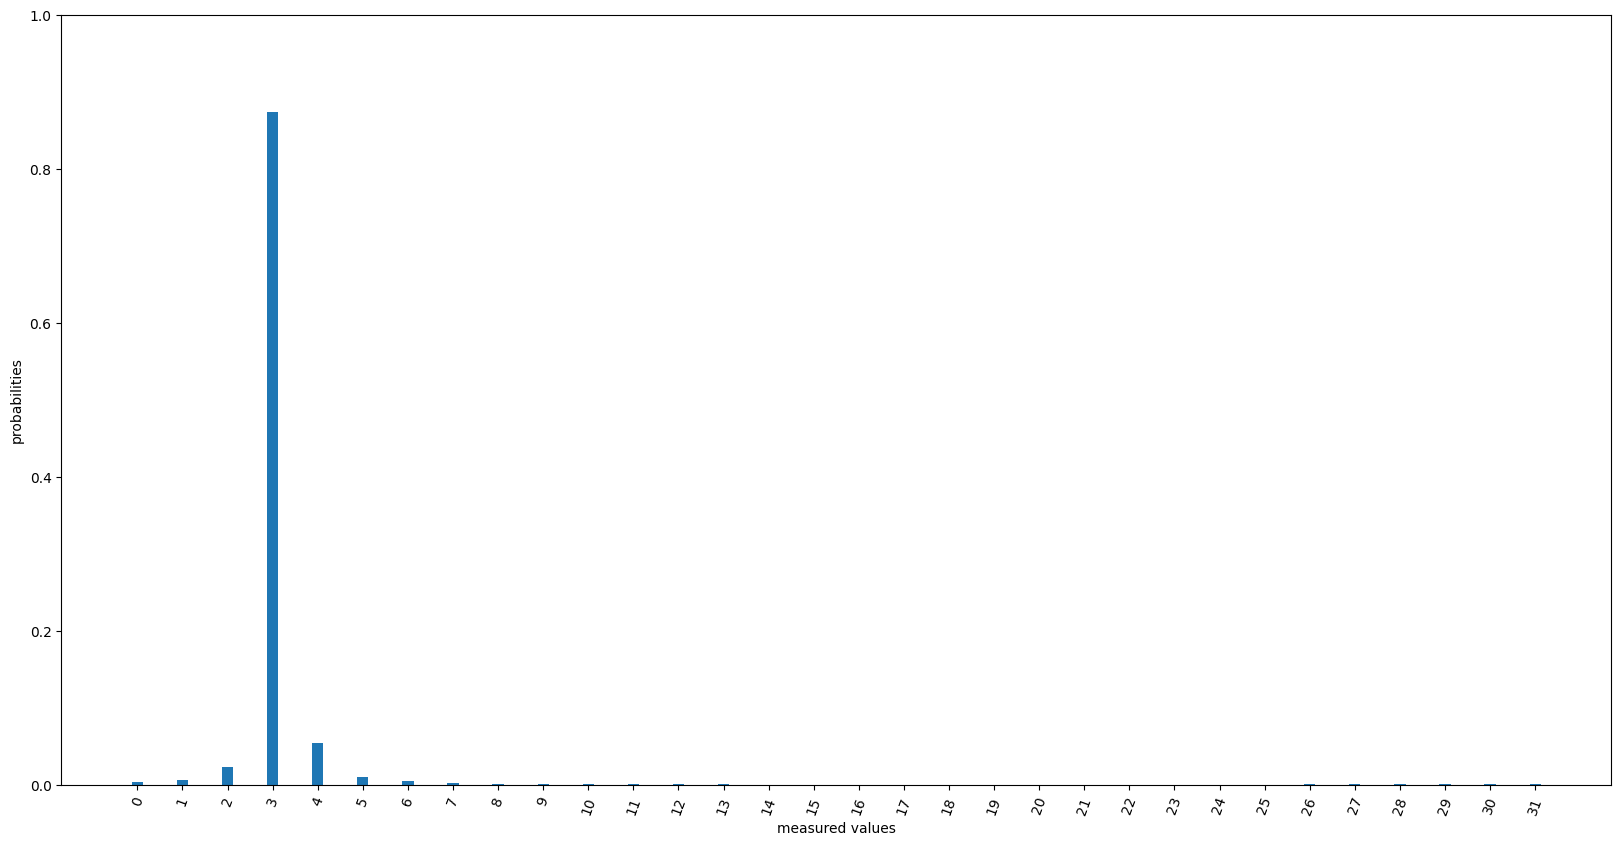

In [190]:
import matplotlib.pyplot as plt
plt.bar(np.arange(0, 2**qubit_num), probs, 0.25)#, width, bottom, align)
plt.xlabel("measured values")
plt.ylabel("probabilities")
plt.ylim(0,1)
plt.xticks(np.arange(0, 2**qubit_num), rotation=70)
# plt.show()
plt.savefig('1_1_16.png')

In [133]:
print((1+0.45)/(2**qubit_num))
total_val = 0
for (prob, val) in zip(probs, np.arange(0,2**qubit_num-1)):
    total_val += prob*val
print(total_val/(2**qubit_num))

0.0453125
0.4837812499999999


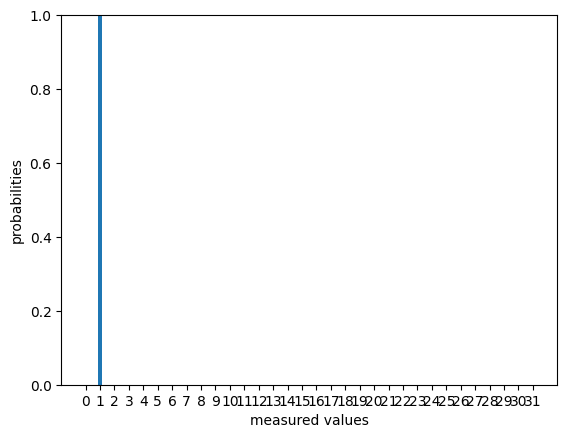

In [18]:
import matplotlib.pyplot as plt
plt.bar(np.arange(0, 2**qubit_num), probs, 0.25)#, width, bottom, align)
plt.xlabel("measured values")
plt.ylabel("probabilities")
plt.ylim(0,1)
plt.xticks(np.arange(0, 2**qubit_num), rotation=70)
# plt.show()
plt.savefig('1_1_32.png')

In [60]:
np.save('matrix.npy', U)

In [63]:
np.load('matrix.npy')
    # a = data['a']

array([[ 0.05433577+0.00054101j,  0.16093934-0.11270894j,
        -0.04026455-0.02919778j, ..., -0.17420091-0.08746285j,
         0.1206118 -0.03384695j,  0.13217655-0.02888537j],
       [ 0.00480864-0.02069883j, -0.02821047-0.11836573j,
        -0.03857152+0.03371295j, ...,  0.09308712-0.0788484j ,
         0.02979492-0.08296977j, -0.15429781+0.03160163j],
       [-0.12589495-0.07846468j, -0.14991248+0.04956598j,
        -0.08261694-0.11963914j, ...,  0.1396407 +0.00340284j,
        -0.1827524 +0.2575682j , -0.02784559+0.00107123j],
       ...,
       [-0.01202071+0.10127694j,  0.07181069+0.0947539j ,
        -0.0517062 +0.07645306j, ...,  0.01359018+0.15944115j,
         0.04282644+0.2678029j ,  0.193259  -0.05940786j],
       [-0.16773428+0.12074372j, -0.0353468 -0.17712848j,
        -0.08313475-0.16990683j, ...,  0.07049509-0.0818754j ,
        -0.03602325+0.1180767j , -0.18650437-0.04306881j],
       [-0.09903159+0.23558741j,  0.08994122+0.04587866j,
         0.11869232+0.08333819

In [19]:
np.save('vector.npy', vecs_u[0])

In [44]:
vec_in_file = np.load('vector.npy')
U = np.load('matrix.npy')
# U = unitary_group.rvs(2**qubit_num)
eigs_u, vecs_u = np.linalg.eig(U)
print(vecs_u[0])
print(vecs_u[:,0])



[-0.16706059-0.05424573j -0.04086089+0.1395898j   0.3189946 +0.j
  0.11596863-0.11472272j  0.22100911-0.03253754j  0.1553115 -0.08565592j
  0.22248404+0.01413891j  0.09444091-0.01975712j -0.18977445-0.09029238j
  0.00740171+0.15395839j -0.04295367-0.23451072j -0.02299969+0.12786178j
  0.04416289+0.10639188j -0.23044963+0.05698477j -0.0933401 -0.13530579j
 -0.05779189+0.06075411j -0.02868067+0.09343493j  0.07756668-0.01830009j
 -0.01039309-0.19023336j  0.03353968+0.06191891j  0.13232957+0.23751739j
  0.18112312+0.2310836j  -0.08576062+0.12596132j -0.16430147-0.07179138j
  0.18182348-0.0155366j   0.05974665-0.10180688j  0.06965111-0.083652j
 -0.03110053+0.1450202j  -0.167722  -0.0510913j  -0.11481964+0.02212165j
 -0.01591718-0.18151657j  0.03216987-0.03928581j]
[-0.16706059-5.42457283e-02j -0.17235516-9.69128553e-03j
 -0.04370883+1.74378639e-02j  0.09008942-1.53158658e-01j
  0.30500648+0.00000000e+00j  0.05155226+4.79613577e-02j
 -0.12917805-1.13244823e-01j  0.02461763-1.76996772e-01j
 -

In [236]:
from scipy.stats import unitary_group

x = unitary_group.rvs(3)*0.001
print(x)


[[ 4.70506929e-05+4.68872443e-04j  5.27165615e-04-6.76829983e-04j
   3.39050197e-05+2.01972529e-04j]
 [-4.58700757e-04+3.92075946e-04j -1.96363459e-04-1.39749342e-04j
   5.80649510e-06-7.60097274e-04j]
 [ 3.20329475e-04+5.57856576e-04j  1.32090289e-05+4.53579788e-04j
   6.16541563e-04+1.23477222e-05j]]


In [243]:
from qiskit.extensions import UnitaryGate
UnitaryGate(x)


ValueError: Input matrix is not unitary.